Assignment 2: 

Name: Young-Shiuan Hsu

UID:118339238

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 


In [82]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
import math
from skimage import color 
%matplotlib inline

In [83]:
# global function that every subproblem will use
def plot2img(img1, img2, title1, title2):
  plt.figure(figsize=(15,20))
  plt.subplot(1, 2, 1)
  plt.title(title1)
  plt.imshow(img1.astype(np.uint8), cmap = 'gray')
  plt.subplot(1, 2, 2)
  plt.title(title2)
  plt.imshow(img2.astype(np.uint8), cmap='gray')

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [84]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 244MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

(51, 480, 512)


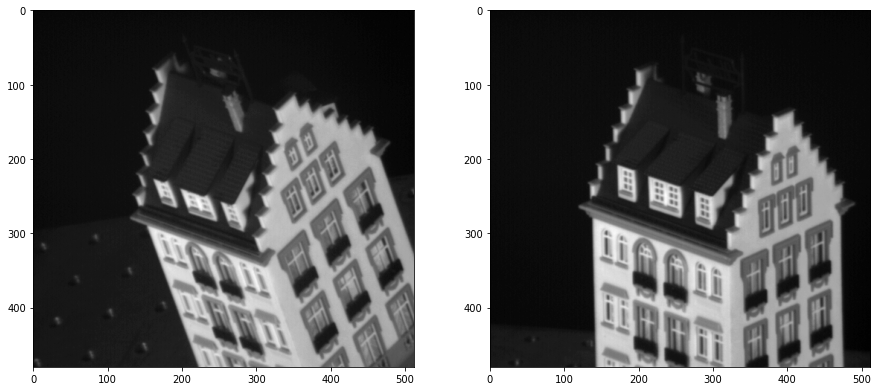

In [100]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y
  outoftrack = []
  plt.figure()
  plt.title("Points lost track")

  for t in range(nim-1):
    print("Processing image: ",t)
    track_x[:, t+1], track_y[:, t+1], outoftrack_temp = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)
    x_temp = outoftrack_temp[:,0]
    y_temp = outoftrack_temp[:,1]
    plt.scatter(x_temp, y_temp, color='g')
    # outoftrack.append(outoftrack_temp)
  plt.imshow(im[0], cmap = 'gray')
  plt.show()
  
  return track_x, track_y

def img2gray(img):
  grayimg = []
  for i in range(img.shape[0]):
    grayimg.append(color.rgb2gray(img[i, :, :, :]))
  grayimg = np.array(grayimg)
  return grayimg

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 
im = img2gray(im)  #convert the 51 images to grayscale
plot2img(im[0], im[50], '', '') ## plot the first and the last image
print(im.shape)


## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

In [86]:
def gradient(patch):
  patchsize = patch.shape[0]
  output_patch = []
  x_gradient = 0
  y_gradient = 0
  xy_gradient = 0
  
  counter = 0
  for i in range(patchsize-1):
    x_gradient += (patch[counter][i] - patch[counter][i+1])**2
    y_gradient += (patch[i][counter] - patch[i+1][counter])**2 
    xy_gradient += (patch[counter][i] - patch[counter][i+1])*(patch[i][counter]-patch[i+1][counter])
    counter += 1
  output_patch = [[x_gradient, xy_gradient],
                  [xy_gradient, y_gradient]]
  output_patch = np.array(output_patch)
  return output_patch

def herris_eigen(H):
  det = np.linalg.det(H)
  tr = H.trace()
  if tr == 0:
    # print("TR = 0")
    return det
  else:
    return det/tr

def nonmaximum_suppression(img):
  kernel_size = 5
  half_kernel_size = math.floor(kernel_size/2)
  new_img = np.zeros((img.shape[0]+kernel_size, img.shape[1]+kernel_size))
  new_img[half_kernel_size:img.shape[0]+half_kernel_size, half_kernel_size:img.shape[1]+half_kernel_size] = img
  for i in range(half_kernel_size, new_img.shape[0]-half_kernel_size, 1):
    for j in range(half_kernel_size, new_img.shape[1]-half_kernel_size, 1):
      patch = new_img[i-half_kernel_size:i+half_kernel_size+1, j-half_kernel_size:j+half_kernel_size+1]
      xx,yy = np.unravel_index(patch.argmax(), patch.shape)
      new_patch = np.zeros(patch.shape)
      new_patch[xx][yy] = patch[xx][yy]
      new_img[i-half_kernel_size:i+half_kernel_size+1, j-half_kernel_size:j+half_kernel_size+1] = new_patch

  new_img = new_img[half_kernel_size:img.shape[0]-half_kernel_size, half_kernel_size:img.shape[1]-half_kernel_size]
  return new_img

def img2list(img):
  corner_list = []
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      temp = []
      pixel_val = img[i][j]
      if np.sum(pixel_val) >= 50:
        temp.append(j)
        temp.append(i)
        corner_list.append(temp)
  corner_list = np.array(corner_list)
  return corner_list


def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  corner_energy = np.zeros(img.shape)
  # construct 2*2 patch -> calculate H matrix -> pass threshold -> max suppression -> return the matrix that contains f
  patchsize = 5
  H = np.zeros((patchsize, patchsize))  ## note the stride is 1
  boundX = img.shape[0] - patchsize
  boundY = img.shape[1] - patchsize
  for i in range(boundX):
    for j in range(boundY):
      patch = img[i:i+patchsize, j:j+patchsize]
      H = gradient(patch)   # construct the H matrix
      eigen = herris_eigen(H)   
      if eigen > tau:     ## check if pass the threshole
        corner_energy[i][j] = eigen
      else:
        corner_energy[i][j] = 0

  suppress_corner_energy = nonmaximum_suppression(corner_energy)

  # plot2img(corner_energy, suppress_corner_energy, 'Corner Energy', 'Suppress Corner Energy') ## plot the first and the last image

  ## change the key points to an array

  return suppress_corner_energy

# compute keypoints in the first sequence


From image index 0 there are 545 keypoints


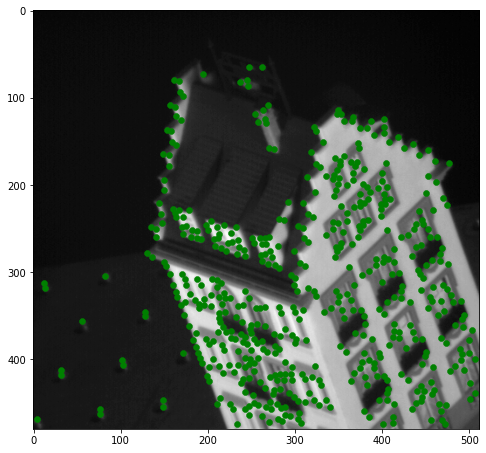

In [87]:
tau = 0.08
key_pts = getKeypoints(im[0], tau)
corner_list = img2list(key_pts)
key_pts = corner_list

x = corner_list[:,0]
y = corner_list[:,1]
plt.figure(figsize = (8,10))
print("From image index 0 there are", len(x), "keypoints")
plt.scatter(x, y, color="g", linewidth=0.5)
plt.imshow(im[0].astype(np.uint8), cmap = 'gray')
plt.show()

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**

1. For each 5*5 window we calculate the gradient on the xias and yias in the window to construct the H matrix. Then calculate f = det(H) / Tr(H) and see if it passes the threshold. After the threshold, we perform maximum suppression(explained in HW1) to calculate the location of corners. 
2. The plot is shown above. 

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

Processing image:  0
Processing image:  1
Processing image:  2
Processing image:  3
Processing image:  4
Processing image:  5
Processing image:  6
Processing image:  7
Processing image:  8
Processing image:  9
Processing image:  10
Processing image:  11
Processing image:  12
Processing image:  13
Processing image:  14
Processing image:  15
Processing image:  16
Processing image:  17
Processing image:  18
Processing image:  19
Processing image:  20
Processing image:  21
Processing image:  22
Processing image:  23
Processing image:  24
Processing image:  25
Processing image:  26
Processing image:  27
Processing image:  28
Processing image:  29
Processing image:  30
Processing image:  31
Processing image:  32
Processing image:  33
Processing image:  34
Processing image:  35
Processing image:  36
Processing image:  37
Processing image:  38
Processing image:  39
Processing image:  40
Processing image:  41
Processing image:  42
Processing image:  43
Processing image:  44
Processing image:  4

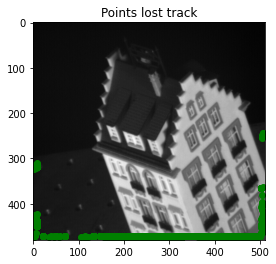

In [104]:
class feature_tracking():
  def __init__(self, key1X, key1Y, key2X, key2Y, img1, img2, ws):
    self.key1X = np.array(key1X)
    self.key1Y = np.array(key1Y)
    self.key2X = np.array(key2X)
    self.key2Y = np.array(key2Y)
    self.img1 = img1
    self.img2 = img2
    self.ws = ws
    self.iternum = 5
    self.outoftrack = []
  
  def check_pointRange(self, temp_X, temp_Y):
    flag = []
    for i in range(temp_X.shape[0]):
      temp = [temp_X[i], temp_Y[i]]
      if temp_X[i] < (self.img1.shape[1]-math.ceil(self.ws/2)-1) and temp_Y[i] < (self.img1.shape[0]-math.ceil(self.ws/2)-1):
        if temp_X[i] > math.ceil(self.ws/2) and temp_Y[i] > math.ceil(self.ws/2):
          flag.append(1)
        else:
          if temp not in self.outoftrack:
            self.outoftrack.append(temp)
          flag.append(0)
      else:
        if temp not in self.outoftrack:
          self.outoftrack.append(temp)
        flag.append(0)
    return np.array(flag)

  def img1_gradient(self):
    x_grad = np.zeros((self.img1.shape))
    y_grad = np.zeros((self.img1.shape))
    for i in range(1,self.img1.shape[0]):  ## row
      for j in range(1,self.img1.shape[1]):  ## col
        x_grad[i][j] = self.img1[i][j] - self.img1[i][j-1]
    
    for i in range(1,self.img1.shape[1]):
      for j in range(1, self.img1.shape[0]):
        y_grad[j][i] = self.img1[j][i] - self.img1[j-1][i]

    return np.array(x_grad), np.array(y_grad)
  
  def get_patch(self, xlocation, ylocation, img, ws):
    xlocation = int(xlocation)
    ylocation = int(ylocation)
    patch = np.zeros((ws,ws))
    half_size = math.floor(ws/2)
    patch = img[ylocation-half_size:ylocation+half_size+1, xlocation-half_size:xlocation+half_size+1]
    return patch

  def A_constructor(self, patchgrad_x, patchgrad_y):
    A = np.zeros((2,2))
    winsize = patchgrad_x.shape[0]
    for i in range(winsize):
      for j in range(winsize):
        A[0][0] += patchgrad_x[i][j]**2
        A[0][1] += patchgrad_x[i][j]*patchgrad_y[i][j]
        A[1][1] += patchgrad_y[i][j]**2
    A[1][0] = A[0][1]
    return A  

  def b_constructor(self, patchdiff, patchgrad_x, patchgrad_y):
    b = np.zeros((2,1))
    winsize = patchgrad_x.shape[0]
    for i in range(winsize):
      for j in range(winsize):
        b[0][0] += patchgrad_x[i][j] * patchdiff[i][j]
        b[1][0] += patchgrad_y[i][j] * patchdiff[i][j]

    b = b*-1
    return b

  # def patch_interpolation(self, xlocation, ylocation):


  def get_motionVector(self, x, y, newx, newy):
    x_grad, y_grad = self.img1_gradient()  ## compute the gradient in img1
    updatex = x
    updatey = y
    if x.shape[0] > newx.shape[0]:
      feature_num = newx.shape[0]
    else:
      feature_num = x.shape[0] 
    target_range = self.check_pointRange(newx, newy)
    ## we will first encounter the first problem where #features img1 > img2
    for iter in range(self.iternum):
      updatex = np.round(updatex)
      updatey = np.round(updatey)
      #we only update those that are in image range
      range_switch = self.check_pointRange(updatex, updatey)
      for feature_idx in range(feature_num):
        if range_switch[feature_idx]:
          patch1 = self.get_patch(updatex[feature_idx], updatey[feature_idx], self.img1, self.ws)
          # patch2 = self.get_patch(updatex[feature_idx], updatey[feature_idx], self.img2, self.ws)
          if target_range[feature_idx]:
            patch2 = self.get_patch(updatex[feature_idx], updatey[feature_idx], self.img2, self.ws)
          else:
            patch2 = np.zeros((self.ws, self.ws))
          patch_diff = patch2 - patch1
          patchgrad_x = self.get_patch(updatex[feature_idx], updatey[feature_idx], x_grad, self.ws)
          patchgrad_y = self.get_patch(updatex[feature_idx], updatey[feature_idx], y_grad, self.ws)
          A = self.A_constructor(patchgrad_x, patchgrad_y)
          b = self.b_constructor(patch_diff, patchgrad_x, patchgrad_y)
          if np.linalg.det(A) == 0:
            print("A matrix is singular")
            motionVector = np.zeros((2,1))
          else:
            motionVector = np.linalg.solve(A, b)
          updatex[feature_idx] += motionVector[0][0]
          updatey[feature_idx] += motionVector[1][0]
      
    return updatex, updatey


def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im2
  ws: patch window size
  output: tracked keypoint positions in im2
  '''
  # calculate A and b matrix from im1, im2 and find the movement vector and then update x, y
  # half_patch = math.floor(ws/2)
  #get feature in im2
  key_pts2 = getKeypoints(im2, tau)
  corner_list2 = img2list(key_pts2)
  new_x = corner_list2[:,0]  
  new_y = corner_list2[:,1]  

  track_feature = feature_tracking(x, y, new_x, new_y, im1, im2, ws)
  # print("Keypoints in img1:", track_feature.key1X.shape[0], "Keypoints in img2:", track_feature.key2X.shape[0])
  updatex, updatey = track_feature.get_motionVector(x, y, new_x, new_y)

  return updatex, updatey, np.array(track_feature.outoftrack)
ws = 15
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

In [117]:
tracked_pts = np.array(tracked_pts)

# plt.figure(figsize = (10,15))
# plt.title("Feature tracking with background img50")
# for i in range(tracked_pts.shape[1]):
#   test_x = tracked_pts[0, i, :]
#   test_y = tracked_pts[1, i, :]
#   plt.plot(test_x, test_y, color='r', linewidth=3)
# plt.imshow(im[50], cmap='gray')
# plt.show()

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





1. displayed below

2. displayed below

3. displayed two cells above(named as "Points lost track"). I have to change slightly modify the trackPoints function in order to keep track of the lost points across frames.  

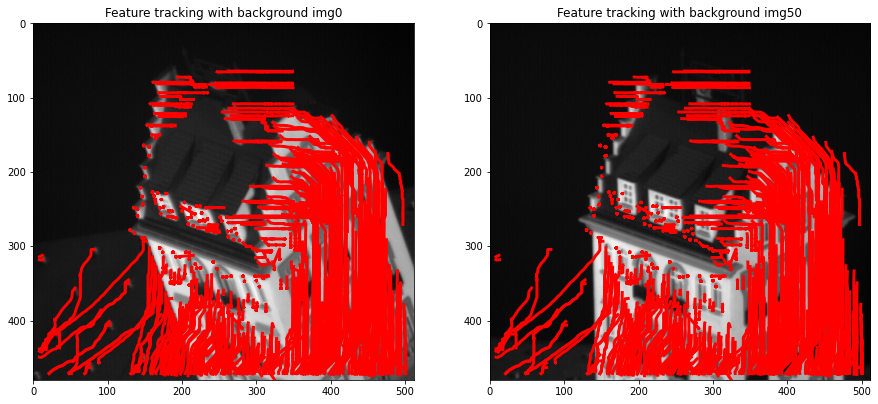

(2, 545, 51)


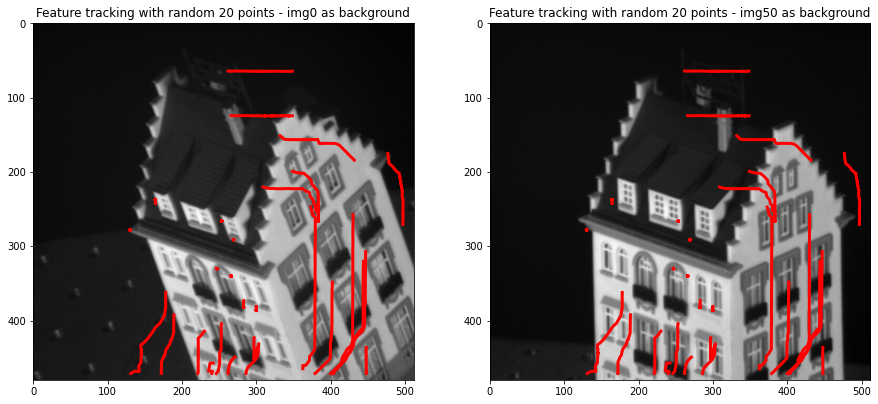

In [118]:
##　plots required in the write up section
def writeup1(tracked_pts, im):
  plt.figure(figsize = (15,20))
  plt.subplot(1,2,1)
  plt.title("Feature tracking with background img0")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[0], cmap='gray')
  plt.subplot(1,2,2)
  plt.title("Feature tracking with background img50")
  for i in range(tracked_pts.shape[1]):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[50], cmap='gray')
  plt.show()

def writeup2(tracked_pts, im):
  print(tracked_pts.shape)
  plt.figure(figsize = (15,20))
  plt.subplot(1,2,1)
  plt.title("Feature tracking with random 20 points - img0 as background")
  for i in range(0,tracked_pts.shape[1], 20):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[0], cmap='gray')
  plt.subplot(1,2,2)
  plt.title("Feature tracking with random 20 points - img50 as background")
  for i in range(0,tracked_pts.shape[1], 20):
    test_x = tracked_pts[0, i, :]
    test_y = tracked_pts[1, i, :]
    plt.plot(test_x, test_y, color='r', linewidth=3)
  plt.imshow(im[50], cmap='gray')


writeup1(tracked_pts, im)
writeup2(tracked_pts, im)

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [3]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 69.9MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

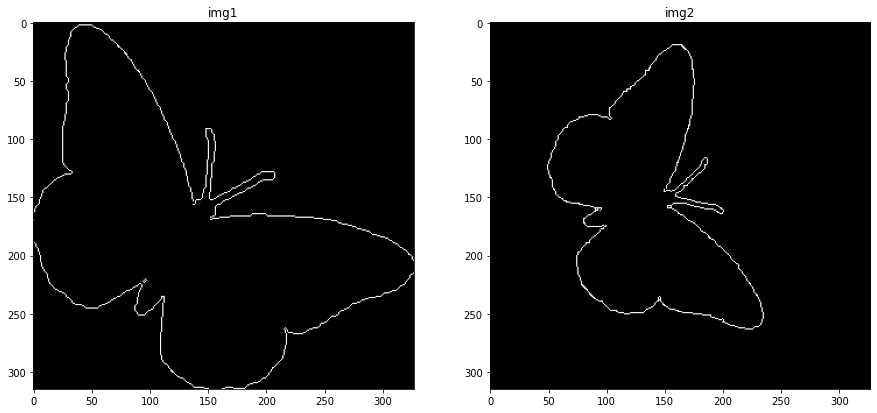

In [9]:
## show image 
img1 = cv2.imread('/content/part2_images/butterfly_1.png')
img2 = cv2.imread('/content/part2_images/butterfly_2.png')
img1 = color.rgb2gray(img1)
img2 = color.rgb2gray(img2)
plot2img(img1, img2, 'img1', 'img2')
# for i in range(img1.shape[0]):
#   for j in range(img1.shape[1]):
#     if img1[i][j] > 0:
#       print(img1[i][j])


## Helper Functions

In [73]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim

def draw_img(edge, img):
  canvas = np.zeros(img.shape)
  for i in range(edge.shape[1]):
    if edge[0][i] < img.shape[1] and edge[1][i] < img.shape[0]:
      canvas[int(edge[1][i])][int(edge[0][i])] = 1
  return canvas
  

## Code (15 pts)

In [71]:
class correlation():
  def __init__(self, data1, data2):
    self.data1 = data1
    self.data2 = data2
    self.P_centered = []
    self.Q_centered = []
    self.cores = []

    self.centered_data()

  def cal_mean(self):
    self.data1_mean = np.zeros((2,1))
    self.data2_mean = np.zeros((2,1))
    for i in range(self.data1.shape[1]):
      self.data1_mean[0][0] += self.data1[0][i] / self.data1.shape[1]
      self.data1_mean[1][0] += self.data1[1][i] / self.data1.shape[1]
    for i in range(self.data2.shape[1]):
      self.data2_mean[0][0] += self.data2[0][i] / self.data2.shape[1]
      self.data2_mean[1][0] += self.data2[1][i] / self.data2.shape[1]
    return np.array(self.data1_mean), np.array(self.data2_mean)

  def centered_data(self):
    Pmean, Qmean = self.cal_mean()
    self.P_centered = self.data1 - Pmean
    self.Q_centered = self.data2 - Qmean

  def find_closest_data_idx(self):
    min_index = []
    # min_dis = []
    idx = []
    for i in range(len(self.P_centered[0])):
      target_data = []
      target_data.append(self.P_centered[0][i])
      target_data.append(self.P_centered[1][i])
      dis = 99999.0
      index = -1
      for j in range(len(self.Q_centered[0])):
        ref_data = []
        ref_data.append(self.Q_centered[0][j])
        ref_data.append(self.Q_centered[1][j])
        distance = math.sqrt(((ref_data[0]-target_data[0])**2)+((ref_data[1]-target_data[1])**2))
        if distance < dis:
          index = j
          dis = distance
      idx.append(i)
      min_index.append(index)
      # min_dis.append(dis)
    self.cores.append(idx)
    self.cores.append(min_index)
    # self.cores.append(min_dis)
    return np.array(self.cores)

  def cross_corre(self):  ## calculate the cross covariance and mean values of the matched points
    self.cross = np.zeros((2,2))
    for i in range(len(self.cores[0])):
      self.cross[0][0] += self.P_centered[0][self.cores[0][i]]*self.Q_centered[0][self.cores[1][i]]
      self.cross[1][0] += self.P_centered[0][self.cores[0][i]]*self.Q_centered[1][self.cores[1][i]]
      self.cross[0][1] += self.P_centered[1][self.cores[0][i]]*self.Q_centered[0][self.cores[1][i]]
      self.cross[1][1] += self.P_centered[1][self.cores[0][i]]*self.Q_centered[1][self.cores[1][i]]
    
    self.cross = self.cross / len(self.P_centered[0])
    
    return self.cross

def edge_update(edge, R, t):
  newedge = np.zeros(edge.shape)
  for i in range(edge.shape[1]):
    target = [ [edge[0][i]],[edge[1][i]] ]
    update = np.dot(R, target) + t
    newedge[0][i] = np.round(update[0][0])
    newedge[1][i] = np.round(update[1][0])
  print(newedge.shape)
  return newedge

In [120]:
class gradient_img():   ## only accept grascale image
  def __init__(self, img):
    self.img = img
    self.x_grad = np.zeros(img.shape)
    self.y_grad = np.zeros(img.shape)

    self.cal_gradient(img)

  def cal_gradient(self, img):
    for i in range(1,img.shape[0]):
      for j in range(1,img.shape[1]):
        self.x_grad[i][j] = self.img[i][j] - self.img[i][j-1]
        self.y_grad[i][j] = self.img[i][j] - self.img[i-1][j]

def edge2list(img):
  x_location = []
  y_location = []
  threshold = 1
  grad_img = gradient_img(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if abs(grad_img.x_grad[i][j]) >= threshold or abs(grad_img.y_grad[i][j]) >= threshold:
        x_location.append(i)
        y_location.append(j)
  location = []
  location.append(y_location)
  location.append(x_location)
  return location

def object_center(edges):
  total_x = np.sum(edges[0,:])
  total_y = np.sum(edges[1,:])
  scaling_x = np.var(edges[0,:])
  scaling_y = np.var(edges[1, :])
  return total_x/len(edges[0]), total_y/len(edges[1]), math.sqrt(scaling_x), math.sqrt(scaling_y)

def init_data(data1, data2):
  ## move and scale data1 to data2
  data1_x = data1[0,:]
  data1_y = data1[1,:]
  data2_x = data2[0,:]
  data2_y = data2[1,:]
  c1_x, c1_y, var1_x, var1_y = object_center(data1)
  c2_x, c2_y, var2_x, var2_y = object_center(data2)
  move_x = c1_x - c2_x
  move_y = c1_y - c2_y
  # print(abs((var1_x/var2_x) - (var1_y/var2_y)))
  if abs((var1_x/var2_x) - (var1_y/var2_y)) > 1:  ## to make sure if they are flipped image
    new_data1_x = data1_x - move_x  
    new_data1_y = data1_y - move_y  
  else:
    new_data1_x = data1_x*(var2_x/var1_x) - move_x  
    new_data1_y = data1_y*(var2_y/var1_y) - move_y  
  newdata = []
  newdata.append(new_data1_x)
  newdata.append(new_data1_y)
  return np.array(newdata)

def check_range(edge, img):
  checked_edge = []
  x=[]
  y=[]
  for i in range(edge.shape[1]):
    if edge[0][i] < img.shape[1] and edge[1][i]<img.shape[0]:
      x.append(edge[0][i])
      y.append(edge[1][i])
  checked_edge.append(x)
  checked_edge.append(y)
  return np.array(checked_edge)

class shape_align():
  def __init__(self, edge1, edge2, im1, im2, iternum):
    self.data1 = np.array(edge1)
    self.data2 = np.array(edge2)
    self.img1 = im1
    self.img2 = im2
    self.iternum = iternum

  def Eucli_distance(self, point1, point2):
    return math.sqrt(((point1[0]-point2[0])**2) + ((point1[1]-point2[1])**2))

  def find_nearest_neighbor(self, datalocation):
    corres = []
    data1location = []
    data2location = []
    dist_tracker = []
    for i in range(datalocation.shape[1]):
      data1location.append(i)
      minDistance = 99999
      idx = -1
      target = datalocation[:,i]
      for j in range(self.data2.shape[1]):
        refer = self.data2[:,j]
        distance = self.Eucli_distance(target, refer)
        if distance < minDistance:
          minDistance = distance
          idx = j
      data2location.append(idx)
      dist_tracker.append(minDistance)
    corres.append(data1location)
    corres.append(data2location)
    corres.append(dist_tracker)
    corres = np.array(corres)
    return corres

  def T_construct(self, corres):
    T = []
    for i in range(corres.shape[1]):
      temp1 = [self.data1[0][int(corres[0][i])], self.data1[1][int(corres[0][i])], 0, 0, 1, 0]
      temp2 = [0, 0, self.data1[0][int(corres[0][i])], self.data1[1][int(corres[0][i])], 0, 1]
      T.append(temp1)
      T.append(temp2)
    return np.array(T)

  def b_construct(self, corres):
    b = []
    for i in range(corres.shape[1]):
      b.append(self.data2[0][int(corres[1][i])])
      b.append(self.data2[1][int(corres[1][i])])
    return np.transpose(np.array(b))

  def get_Vector(self, T, b):
    A = np.transpose(T) @ T  # turn T into N*N matrix
    v = np.transpose(T) @ b
    # motion = np.transpose(np.linalg.solve(A, v))
    # motion = np.linalg.lstsq(T, b, rcond=None)[0]
    B = np.linalg.pinv(T)
    motion = np.dot(B, b)
    print(motion)

    R = np.zeros((2,2))
    R[0][0] = motion[0]
    R[0][1] = motion[1]
    R[1][0] = motion[2]
    R[1][1] = motion[3]

    t = np.zeros((2,1))
    t[0][0] = motion[4]
    t[1][0] = motion[5]

    # R[0,:] = R[0,:]/np.sum(R[0,:])  ## normalize matrix
    # R[1,:] = R[1,:]/np.sum(R[1,:])

    full_matrix = []
    full_matrix.append([R[0][0], R[0][1], t[0][0]])
    full_matrix.append([R[1][0], R[1][1], t[1][0]])
    full_matrix.append([0, 0, 1])
    return R, t, full_matrix
  
  def updateLocation(self, edge, R, t):
    newedge = np.zeros(edge.shape)
    for i in range(edge.shape[1]):
      target = [ [edge[0][i]],[edge[1][i]] ]
      update = np.dot(R, target) + t
      newedge[0][i] = np.round(update[0][0])
      newedge[1][i] = np.round(update[1][0])
    print(newedge.shape)
    # print(x_location)
    # print(y_location)
    return np.array(newedge)

  # def tester(self, R, t):
  #   print(np.dot(T, self.data1)+t)

  def match_shape(self):
    matrix_tracker = []
    current_location = self.data1
    # print("Feature number:", self.data1.shape[1], self.data2.shape[1])
    # self.plot_edges(current_location, self.data2, self.img1, self.img2)

    for iter in range(self.iternum):
      self.plot_edges(current_location, self.data2, self.img1, self.img2)
      print("Running iteration:", iter)
      ## find nearest neighbors 
      correspond = self.find_nearest_neighbor(current_location)
      ## Solve T and b matrix for R and t
      T = self.T_construct(correspond)
      b = self.b_construct(correspond)
      R, t, fullMatrix = self.get_Vector(T, b)
      print("R:", R)
      print("t:", t)
      matrix_tracker.append(fullMatrix)  ## keep track of R and t
      # ## update the edge from img1
      current_location = self.updateLocation(current_location, R, t)
      current_location = np.round(current_location)
      # print(current_location)

    self.plot_edges(current_location, self.data2, self.img1, self.img2)  

    return current_location, np.array(matrix_tracker)
      
  def plot_edges(self, edge1, edge2, im1, im2):
    plt.figure()
    plt.scatter(edge1[0,:], edge1[1,:], color = 'r')
    plt.scatter(edge2[0,:], edge2[1,:], color = 'b')
    plt.imshow(im2.astype(np.uint8), cmap='gray')
    plt.show()

def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2
  Output: transformation T [3] x [3]
  '''
  mode = 2

  edge1 = np.array(edge2list(im1))
  edge2 = np.array(edge2list(im2))
  edge1 = init_data(edge1, edge2)
  # # print("Size of feature in the two images:",edge1.shape, edge2.shape)
  # # print(edge1.shape, edge2.shape)

  if mode == 1:
    iternum = 3
    shapeAlign = shape_align(edge1, edge2, im1, im2, iternum)
    # shapeAlign.plot_edges(edge1, edge2, im1, im2)
    updated_location, matrix_tracker = shapeAlign.match_shape()

  else:
    iternum = 50
    track_matrix = []
    err = []
    print("Running Shape alignment with iteration=", iternum)
    for iter in range(iternum):
      # print("Running iteration:", iter)
      corr = correlation(edge1, edge2)
      cores = corr.find_closest_data_idx()
      corre_matrix = corr.cross_corre()

      U, S, V = np.linalg.svd(corre_matrix)
      R = np.dot(U,V)
      T = corr.data2_mean - np.dot(R, corr.data1_mean)
      edge1 = np.dot(R, edge1)+T

      #reconstruct R matrix for tracking
      feature1 = [R[0][0], R[0][1], T[0][0]]
      feature2 = [R[1][0], R[1][1], T[1][0]]
      feature3 = [0, 0, 1]
      final_matrix =[]
      final_matrix.append(feature1)
      final_matrix.append(feature2)
      final_matrix.append(feature3)
      track_matrix.append(final_matrix)

    plt.figure()
    plt.scatter(edge1[0,:], edge1[1,:], color = 'r')
    plt.scatter(edge2[0,:], edge2[1,:], color = 'b')
    plt.imshow(im2.astype(np.uint8), cmap='gray')
    plt.show()

    ## evaluate the error
    new_aligned_img = draw_img(edge1, im1)
    err.append(evalAlignment(new_aligned_img, im2))
  # print("Final Result after", iternum, "iterations")
  # plot_data(edge1, edge2, "P: moved data", "Q: true data")
  return np.array(track_matrix), err

Processing image: butterfly
Running Shape alignment with iteration= 50


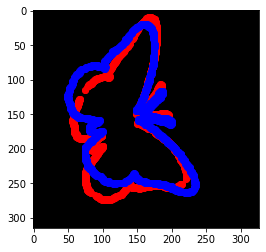

Error value of the final aligned shapes:
Processing image: chicken
Running Shape alignment with iteration= 50


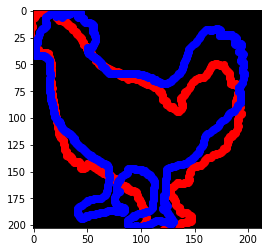

Error value of the final aligned shapes:
[[3.3446606361677964], [4.673141375499207]]


In [121]:
imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']
partial_objList = ['apple', 'elephant', 'butterfly', 'bottle', 'cattle']

numObj = len(objList)

## Run shape alignment
## change to 1 to run all the examples 
run = 3
error = []
if run == 1:  ##run all the images
  for img_name in objList:
    img1 = cv2.imread(imgPath+img_name+"_1.png")
    img2 = cv2.imread(imgPath+img_name+"_2.png")
    img1 = color.rgb2gray(img1)
    img2 = color.rgb2gray(img2)
    T, err = align_shape(img1, img2)
    error.append(err)
  print("Error value of the final aligned shapes:")
  print(error)

elif run == 2:  ## run partial images
  for img_name in partial_objList:
    print("Processing image:", img_name)
    img1 = cv2.imread(imgPath+img_name+"_1.png")
    img2 = cv2.imread(imgPath+img_name+"_2.png")
    img1 = color.rgb2gray(img1)
    img2 = color.rgb2gray(img2)
    T, err = align_shape(img1, img2)
    print("Error evaluation:", err)
    error.append(err)
  print("Error value of the final aligned shapes:")
  print(error)

elif run == 3:
  objname = ['butterfly', 'chicken']
  for img_name in objname:
    print("Processing image:", img_name)
    img1 = cv2.imread(imgPath+img_name+"_1.png")
    img2 = cv2.imread(imgPath+img_name+"_2.png")
    img1 = color.rgb2gray(img1)
    img2 = color.rgb2gray(img2)
    T, err = align_shape(img1, img2)
    print("Error value of the final aligned shapes:")
    error.append(err)
  print(error)
# print("Image shapes:", img1.shape, img2.shape)


## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**
1. Algorithm explaination (pseudocode)
I try do implement two different methods. The first method is the algorithm mentioned in the lecture notes by solving the neares corresponding keypoints and update with the v vector(the class shape_align() above). However, when I try to run this algorithm, it is not working. It is only scaling my image smaller and smaller. The second method is the one I found online which solves the rotation matrix with the cross-correlation matrix(the class correlation() above). The result display above is implemented with this method. The only problem is when I try to align "hammer.png" it is not working, with an evaluated error 6.5.

  **Method 1:**

  Initalize data with the mean value of the two images and the variance for scaling. Then they are somehow aligned to each other, then we have to calculate the rotation matrix and shifting vector with iteration

  for every iteration:

  Initialize data with mean and variance <- pretty sure I done this correctly
for every iteration

  a. we find the corresponding nearest nonzero coordinates in im2 for every keypoints in im1

  b. we construct A matrix with the coordinates in im1, and b matrix with corresponding coordinates in im2(showed in the slides)

  c. (A.transpose() * A ) * v = A.transpose() * b and solve v vector with np.linalg.solve() <- since np.linglg.solve only takes squared matrix

  d. new_location = R*(coordinates in im1) + t

  e. start again from step a

  **Method 2:**

  Initalize data mentioned above

  for every iteration:

  a. Find the corresponding nearest nonzero cordinates in im2 for every keypoints in im1

  b. Form a 2*2 cross-correlation matrix with the two keypoints data

  c. Calculate the SVD of the cross-correlation 

  d. R = S*D, t = keypoints2_mean - R * keypoints1_mean

  e. update the corrdinates = R*old_location + t

  f. return to step a

  Reference: https://www.youtube.com/watch?v=6qVZvKIkJMo&t=311s


2. The result is shown in the cell above. Due to running time and deadline of this homework, I am only able to run some images shown above.


3. Runtime: it takes roughly 5 minutes to process a 300*300 image to run 50 iterations.



# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 21.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 83.6MB/s]


## Code (10 pts)

In [ ]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

'''
SIFT descriptor:
16*16 window -> 4*4 grid(cell) -> compute the histogram and orientation of each cell
4*4*8 = 128 description of a 16*16 window 

'''
Frame1 = np.array(Frame1)
Descriptor1 = np.array(Descriptor1)
Frame2 = np.array(Frame2)
Descriptor2 = np.array(Descriptor2)

'''
Frame 1 shape 4*558 [0]
Desript1 shape 128*558 [0]
'''


## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2

## Display the matched keypoints
# YOUR CODE HERE


[  4.04707289 209.86776733   1.81994498  -3.04389868]


In [ ]:
class SIFT():
  def __init__(self, data1, data2, descrip1, descrip2):
    self.data1 = np.array(data1)
    self.data2 = np.array(data2)
    self.descript1 = np.array(descrip1)
    self.descript2 = np.array(descrip2)
    self.correspond = []
  
  def eucli_distance(self, script1, script2):
    ## script1, script2 is 128*1 data
    scriptsize = 128
    total = 0
    for i in range(scriptsize):
      total += (int(script1[i]) - int(script2[i]))**2
      if total > 999999999:
        return 99999999999
    return math.sqrt(total)

  def find_min_correspondance(self):
    print("Creating min correspondance matrix")
    feature1_num = self.descript1.shape[1]
    feature2_num = self.descript2.shape[1]
    data1_idx = []
    data2_idx = []
    corres_distance = []
    for i in range(feature1_num):
      target = self.descript1[:, i]
      data1_idx.append(i)
      minDistance = 9999999
      idx = -1
      for j in range(feature2_num):
        refer = self.descript2[:,j]
        distance = self.eucli_distance(target, refer)
        if distance < minDistance:
          idx = j
          minDistance = distance
      data2_idx.append(idx)
      corres_distance.append(minDistance)
    self.correspond.append(data1_idx)
    self.correspond.append(data2_idx)
    self.correspond.append(corres_distance)
    return np.array(self.correspond)
  
  def create_correspondance_location(self, correspondance):
    corres_data1 = []
    corres_data2 = []
    x2_location = []
    y2_location = []
    x1_location = []
    y1_location = []
    for i in range(correspondance.shape[1]):
      x1_location.append(self.data1[0][int(correspondance[0][i])])
      y1_location.append(self.data1[1][int(correspondance[0][i])])
      x2_location.append(self.data2[0][int(correspondance[1][i])])
      y2_location.append(self.data2[1][int(correspondance[1][i])])

    corres_data1.append(x1_location)
    corres_data1.append(y1_location)
    corres_data2.append(x2_location)
    corres_data2.append(y2_location)
    return np.array(corres_data1), np.array(corres_data2)

  def distance_thresholding(self, threshold):
    datalen = np.array(self.correspond).shape[1]
    threshold_corrs = []
    data1_idx = []
    data2_idx = []
    distance = []
    for i in range(datalen):
      if self.correspond[2][i] < threshold:
        data1_idx.append(self.correspond[0][i])
        data2_idx.append(self.correspond[1][i])
        distance.append(self.correspond[2][i])
    threshold_corrs.append(data1_idx)
    threshold_corrs.append(data2_idx)
    threshold_corrs.append(distance)
    return np.array(threshold_corrs)

  def distance_ratio(self, correspond, threshold):
    refer_len = self.descript2.shape[1]
    new_corres = []
    for i in range(correspond.shape[1]):
      min_distance = correspond[2][i]
      target = self.descript1[:,int(correspond[0][i])]
      possible_match = {}
      possible_match[correspond[1][i]] = 1
      for j in range(refer_len):
        refer = self.descript2[:,j]
        distance = self.eucli_distance(target, refer)
        ratio = min_distance / distance
        if ratio > threshold:
          possible_match[j] = ratio
      new_corres.append(possible_match)  ## store the possible match in a dictionary
    return new_corres


In [ ]:
## set up a SIFT object to find the minimum corresponding distances
SIFT_finder = SIFT(Frame1[0:2,:],Frame2[0:2,:], Descriptor1, Descriptor2)
mindis_corres = SIFT_finder.find_min_correspondance()  ## find the minimum distance

Creating min correspondance matrix


In [ ]:
#meature by distance
def plot_correspond_dist(img1, img2, SIFT_finder, title):
  print("Shape of the two images:", img1.shape, img2.shape)
  if img1.shape[0] > img2.shape[0]:
    rows = img1.shape[0]
  else:
    rows = img2.shape[0]
  cols = img1.shape[1] + img2.shape[1]
  new_canvas = np.zeros((rows, cols, 3))

  new_canvas[0:img1.shape[0], 0:img1.shape[1], :] = img1
  new_canvas[0:img2.shape[0], img1.shape[1]:img1.shape[1]+img2.shape[1], :] = img2

  ## generate correspondance
  threshold = 123  ## set the threshold for the minimum distance array
  core = SIFT_finder.distance_thresholding(threshold)
  data1location, data2location = SIFT_finder.create_correspondance_location(core)
  print("Found", data1location.shape[1], "keypoints with threshold =", threshold)

  plt.figure(figsize = (10,15))
  plt.title('SIFT matching - ' + title)
  for i in range(data1location.shape[1]):
    x_location = [data1location[0][i], img1.shape[1] + data2location[0][i]]
    y_location = [data1location[1][i], data2location[1][i]]
    plt.plot(x_location, y_location, 'bo', linestyle="--")
  plt.imshow(cv2.cvtColor(new_canvas.astype(np.uint8), cv2.COLOR_BGR2RGB))

def get_points_from_dict(dictionary, SIFT_finder):
  x_location = []
  y_location = []
  dict_location = []
  for i in dictionary.keys():
    x_location.append(SIFT_finder.data2[0][int(i)])
    y_location.append(SIFT_finder.data2[1][int(i)])
  dict_location.append(x_location)
  dict_location.append(y_location)
  return np.array(dict_location)

def plot_correspond_distRatio(img1, img2, SIFT_finder, title):
  print("Shape of the two images:", img1.shape, img2.shape)
  if img1.shape[0] > img2.shape[0]:
    rows = img1.shape[0]
  else:
    rows = img2.shape[0]
  cols = img1.shape[1] + img2.shape[1]
  new_canvas = np.zeros((rows, cols, 3))

  new_canvas[0:img1.shape[0], 0:img1.shape[1], :] = img1
  new_canvas[0:img2.shape[0], img1.shape[1]:img1.shape[1]+img2.shape[1], :] = img2

  ## generate correspondance
  threshold = 123  ## set the threshold for the minimum distance array
  core = SIFT_finder.distance_thresholding(threshold)
  data1location, _ = SIFT_finder.create_correspondance_location(core)
  ratio_threshold = 0.75
  corr_dict = SIFT_finder.distance_ratio(core, ratio_threshold)
  print("Found", data1location.shape[1], "keypoints with ratio threshold =", ratio_threshold)

  plt.figure(figsize = (10,15))
  plt.title('SIFT matching - ' + title)
  for i in range(data1location.shape[1]):
    temp_dict = corr_dict[i]
    temp_target = data1location[:,i]
    refer_location = get_points_from_dict(temp_dict, SIFT_finder)
    # print(temp_target, refer_location.shape)
    for j in range(refer_location.shape[1]):
      x_location = [data1location[0][i], img1.shape[1] + refer_location[0][j]]
      y_location = [data1location[1][i], refer_location[1][j]]
      plt.plot(x_location, y_location, 'bo', linestyle="--")
  plt.imshow(cv2.cvtColor(new_canvas.astype(np.uint8), cv2.COLOR_BGR2RGB))


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

Shape of the two images: (480, 355, 3) (683, 1024, 3)
Found 29 keypoints with threshold = 123
Shape of the two images: (480, 355, 3) (683, 1024, 3)
Found 29 keypoints with ratio threshold = 0.75


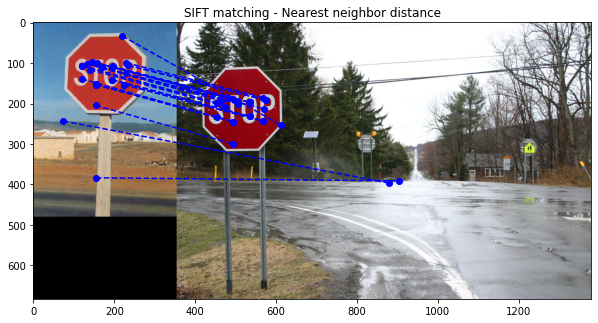

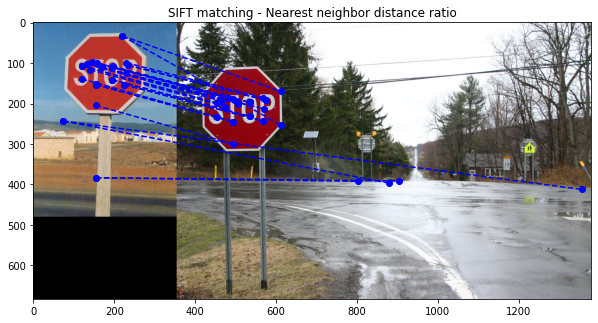

In [ ]:
## plot the corresponding points with minmum distance
plot_correspond_dist(img1, img2, SIFT_finder, 'Nearest neighbor distance')
## plot the corresponding points with distance ratio
plot_correspond_distRatio(img1, img2, SIFT_finder, 'Nearest neighbor distance ratio')

1. Found 29 keypoints with distance threshold = 123
2. Found 29 keypoints with distance ratio threshold = 0.75

If we take the maximum distance threshold of the two SIFT description, we can only find the "Best" correspondance point related to every point in image1. If we take the threshold of the distance ratio(in my case setting the ratio threshold to 0.75) we can find multiple values that are similar to a certain point in img1. It is obvious in the corner of the stop sign on the top right, which maps one point to two other points in img2. 